In [1]:
!pip install mxnet=="1.4.1"

    100% |████████████████████████████████| 28.4MB 1.8MB/s eta 0:00:011
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install gluonts

    100% |████████████████████████████████| 327kB 46.6MB/s ta 0:00:01
    100% |████████████████████████████████| 81kB 48.0MB/s ta 0:00:01
    100% |████████████████████████████████| 10.4MB 4.7MB/s  eta 0:00:01
    100% |████████████████████████████████| 7.1MB 6.9MB/s eta 0:00:011
    100% |████████████████████████████████| 194kB 56.7MB/s eta 0:00:01
    100% |████████████████████████████████| 61kB 36.7MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/41/17/c62faccbfbd163c7f57f3844689e3a78bae1f403648a6afb1d0866d87fbb/python_dateutil-2.8.0-py2.py3-none-any.whl
  Running setup.py bdist_wheel for holidays ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/40/a9/2b/94ac5464363d37564a87dc93a9d21a5850aac14a4608197003
  Running setup.py bdist_wheel for ujson ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/28/77/e4/0311145b9c2e2f01470e744855131f9e34d6919687550f87d1
Successfully built holidays ujson
  Found existing installation: python-dateut

In [3]:
# !pip install gluonts=="0.4.1"

In [3]:
import gluonts
import mxnet

print(gluonts.__version__)
print(mxnet.__version__)

0.4.2
1.4.1


In [4]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar
# from utils_gluonts11_deepstate import deep_state


INFO:root:Using CPU


In [5]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_hourly', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_finance', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_finance', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_quarterly_other', 'm4_weekly', 'm4_weekly_domain', 'my_weekly_tm', 'm4_yearly', 'm4_yearly_demographic', 'm4_yearly_domain', 'm4_yearly_finance', 'm4_yearly_industry', 'm4_yearly_macro', 'm4_yearly_micro', 'm4_yearly_other']


#### Note

In SageMaker data are saved into the following folders (example shows m4_weekly):

```
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/test/data.json
```

In [6]:
dataname = "m4_monthly_micro"
dataset = get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_micro.


In [7]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])


In [8]:
train_entry

{'start': Timestamp('1750-01-31 00:00:00', freq='M'),
 'target': array([ 3396.89,  3257.99,  3158.49,  3176.81,  3157.27,  3108.64,
         3063.8 ,  3098.17,  3106.87,  3096.37,  3193.22,  3230.99,
         3329.66,  3278.32,  3228.59,  3196.76,  3178.63,  3210.04,
         3236.73,  3281.7 ,  3298.  ,  3292.78,  3283.29,  3283.5 ,
         3266.97,  3238.75,  3228.64,  3275.36,  3289.36,  3304.42,
         3386.32,  3449.33,  3480.2 ,  3488.49,  3489.8 ,  3514.08,
         3509.89,  3507.85,  3535.43,  3557.9 ,  3569.59,  3581.05,
         3568.18,  3565.69,  3606.74,  3631.37,  3675.48,  3681.79,
         3677.63,  3697.65,  3706.94,  3697.  ,  3702.05,  3703.11,
         3677.1 ,  3703.61,  3716.26,  3688.9 ,  3665.12,  3615.87,
         3594.32,  3593.57,  3573.24,  3569.07,  3599.18,  3554.01,
         3484.06,  3424.86,  3433.06,  3373.05,  3448.19,  3465.57,
         3465.6 ,  3485.96,  3497.15,  3530.69,  3557.28,  3557.31,
         3504.81,  3521.84,  3527.23,  3572.4 ,  362

## Plot Series

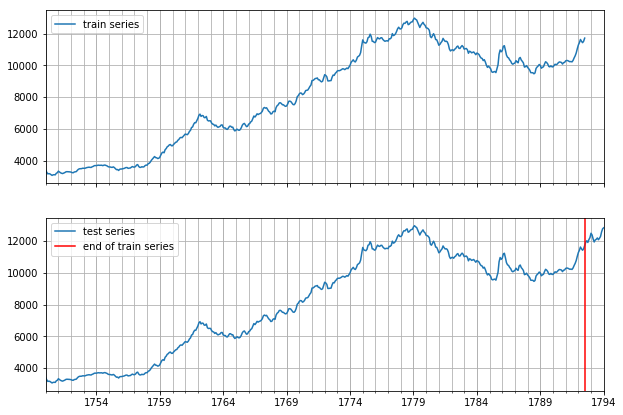

In [9]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [10]:
print("start:", dict(train_entry)["start"])
print("target:", dict(train_entry)["target"][:7])
print("feat_static_cat:", dict(train_entry)["feat_static_cat"])
print("length:", len(dataset.train))

start: 1750-01-31 00:00:00
target: [3396.89 3257.99 3158.49 3176.81 3157.27 3108.64 3063.8 ]
feat_static_cat: [1]
length: 10975


In [11]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepstate import DeepStateEstimator

INFO:root:Using CPU


In [12]:
#########################
### deepstate wrapper ###

# data = "m4_yearly_other"
# seed = 44
# epochs = 500
# num_batches = 100
# batch_size = 32

def deepstate(dataname, seed=42, epochs=100, num_batches=50):
    
    mx.random.seed(seed)
    np.random.seed(seed)

    dataset = get_dataset(dataname, regenerate=False)

    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=num_batches,
        learning_rate=1e-3,
        )

    cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
    estimator = DeepStateEstimator(
        trainer=trainer,
        cardinality=[cardinality],
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True,
        )

    predictor=estimator.train(dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
            dataset.test, predictor=predictor, num_samples=100
        )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = num_batches    

    df = pd.DataFrame([output])
    return df

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df=deepstate("m4_monthly_micro", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_micro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]

Seed: 42


INFO:root:Number of parameters in DeepStateTrainingNetwork: 578099
100%|██████████| 100/100 [00:18<00:00,  5.40it/s, avg_epoch_loss=-1.36]
INFO:root:Epoch[0] Elapsed time 18.528 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=-1.360880
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:16<00:00,  6.05it/s, avg_epoch_loss=0.451]
INFO:root:Epoch[1] Elapsed time 16.528 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.450751
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:15<00:00,  6.43it/s, avg_epoch_loss=0.461]
INFO:root:Epoch[2] Elapsed time 15.561 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.460891
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.77it/s, avg_epoch_loss=-.579]
INFO:root:Epoch[3] Elapsed time 17.344 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.579402
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.58it/s, a

INFO:root:Epoch[36] Learning rate is 0.000125
100%|██████████| 100/100 [00:17<00:00,  5.64it/s, avg_epoch_loss=0.465]
INFO:root:Epoch[36] Elapsed time 17.727 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=0.464688
INFO:root:Epoch[37] Learning rate is 0.000125
100%|██████████| 100/100 [00:18<00:00,  5.35it/s, avg_epoch_loss=0.258]
INFO:root:Epoch[37] Elapsed time 18.707 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.258319
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 100/100 [00:17<00:00,  5.60it/s, avg_epoch_loss=-.207]
INFO:root:Epoch[38] Elapsed time 17.868 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-0.207318
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 100/100 [00:15<00:00,  6.37it/s, avg_epoch_loss=0.396]
INFO:root:Epoch[39] Elapsed time 15.696 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.395638
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 100/100 [00:16<00:00,  6.02it/s,

100%|██████████| 100/100 [00:17<00:00,  5.56it/s, avg_epoch_loss=-.355]
INFO:root:Epoch[72] Elapsed time 17.990 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=-0.354879
INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:17<00:00,  5.64it/s, avg_epoch_loss=0.2] 
INFO:root:Epoch[73] Elapsed time 17.724 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.199568
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:17<00:00,  5.78it/s, avg_epoch_loss=0.506]
INFO:root:Epoch[74] Elapsed time 17.308 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.505840
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:15<00:00,  6.57it/s, avg_epoch_loss=-.0113]
INFO:root:Epoch[75] Elapsed time 15.233 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-0.011314
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:16<00:00,  6.01it/s, avg_epoch_loss=-.0449]
INFO:root:Epoch[76] Elapsed time 

INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-0.159429
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:17<00:00,  5.58it/s, avg_epoch_loss=-.236]
INFO:root:Epoch[109] Elapsed time 17.914 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-0.235548
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.53it/s, avg_epoch_loss=-1.7]
INFO:root:Epoch[110] Elapsed time 18.089 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-1.701967
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:16<00:00,  6.14it/s, avg_epoch_loss=-.456]
INFO:root:Epoch[111] Elapsed time 16.286 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-0.455954
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:16<00:00,  6.17it/s, avg_epoch_loss=0.0841]
INFO:root:Epoch[112] Elapsed time 16.207 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=0.084142
INFO:root:Epoch[113] Learning r

INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:17<00:00,  5.57it/s, avg_epoch_loss=-.998]
INFO:root:Epoch[145] Elapsed time 17.952 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-0.998218
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:17<00:00,  5.62it/s, avg_epoch_loss=-.241]
INFO:root:Epoch[146] Elapsed time 17.802 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-0.241046
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:16<00:00,  6.16it/s, avg_epoch_loss=-1.22]
INFO:root:Epoch[147] Elapsed time 16.235 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-1.220934
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:16<00:00,  6.14it/s, avg_epoch_loss=-1.72]
INFO:root:Epoch[148] Elapsed time 16.305 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=-1.724735
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.51it/s

100%|██████████| 100/100 [00:17<00:00,  5.69it/s, avg_epoch_loss=-.581]
INFO:root:Epoch[181] Elapsed time 17.566 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-0.581348
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.51it/s, avg_epoch_loss=-2.52]
INFO:root:Epoch[182] Elapsed time 18.147 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-2.515849
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:16<00:00,  5.90it/s, avg_epoch_loss=-.736]
INFO:root:Epoch[183] Elapsed time 16.951 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-0.735684
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:16<00:00,  6.22it/s, avg_epoch_loss=-.283]
INFO:root:Epoch[184] Elapsed time 16.076 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=-0.283294
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.50it/s, avg_epoch_loss=-2.03]
INFO:root:Epoch[185]

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.100847  0.184762  18.229903            0.172235            0.099297   

   seed  epochs  num_batches  
0    42     200          100  
Seed: 43


INFO:root:Number of parameters in DeepStateTrainingNetwork: 578099
100%|██████████| 100/100 [00:18<00:00,  5.40it/s, avg_epoch_loss=-1.32]
INFO:root:Epoch[0] Elapsed time 18.537 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=-1.324525
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.58it/s, avg_epoch_loss=0.484]
INFO:root:Epoch[1] Elapsed time 17.932 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.484065
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.56it/s, avg_epoch_loss=0.416]
INFO:root:Epoch[2] Elapsed time 17.991 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.415601
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.60it/s, avg_epoch_loss=-.66] 
INFO:root:Epoch[3] Elapsed time 17.858 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.659632
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:18<00:00,  5.53it/s, a

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-0.617380
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.56it/s, avg_epoch_loss=-1.06]
INFO:root:Epoch[37] Elapsed time 17.995 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-1.055308
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:19<00:00,  5.26it/s, avg_epoch_loss=-2.48]
INFO:root:Epoch[38] Elapsed time 19.023 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-2.484009
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.65it/s, avg_epoch_loss=-.867]
INFO:root:Epoch[39] Elapsed time 17.719 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-0.866915
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.62it/s, avg_epoch_loss=-.619]
INFO:root:Epoch[40] Elapsed time 17.797 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=-0.619483
INFO:root:Epoch[41] Learning rate is 0.001


100%|██████████| 100/100 [00:17<00:00,  5.60it/s, avg_epoch_loss=-2.11]
INFO:root:Epoch[72] Elapsed time 17.863 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=-2.113375
INFO:root:Epoch[73] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:17<00:00,  5.61it/s, avg_epoch_loss=-.981]
INFO:root:Epoch[73] Elapsed time 17.819 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-0.980511
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:17<00:00,  5.71it/s, avg_epoch_loss=-.103]
INFO:root:Epoch[74] Elapsed time 17.521 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-0.103373
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:17<00:00,  5.59it/s, avg_epoch_loss=-1.03]
INFO:root:Epoch[75] Elapsed time 17.881 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-1.029242
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:18<00:00,  5.53it/s, avg_epoch_loss=-1.66]
INFO:root:Epoch[76] 

100%|██████████| 100/100 [00:17<00:00,  5.64it/s, avg_epoch_loss=-.562]
INFO:root:Epoch[108] Elapsed time 17.746 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-0.561936
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.29it/s, avg_epoch_loss=-.742]
INFO:root:Epoch[109] Elapsed time 18.909 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-0.742373
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.51it/s, avg_epoch_loss=-2.44]
INFO:root:Epoch[110] Elapsed time 18.170 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-2.436806
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.52it/s, avg_epoch_loss=-.644]
INFO:root:Epoch[111] Elapsed time 18.109 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-0.643887
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:17<00:00,  5.66it/s, avg_epoch_loss=-.469]
INFO:root:Epoch[112]

100%|██████████| 100/100 [00:18<00:00,  5.41it/s, avg_epoch_loss=-2.53]
INFO:root:Epoch[144] Elapsed time 18.496 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=-2.533642
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:18<00:00,  5.51it/s, avg_epoch_loss=-1.18]
INFO:root:Epoch[145] Elapsed time 18.168 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-1.184314
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:17<00:00,  5.60it/s, avg_epoch_loss=-.525]
INFO:root:Epoch[146] Elapsed time 17.857 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-0.525241
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:17<00:00,  5.62it/s, avg_epoch_loss=-1.56]
INFO:root:Epoch[147] Elapsed time 17.794 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-1.562849
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:17<00:00,  5.58it/s, avg_epoch_loss=-2.01]
INFO:root:Epoch[148]

100%|██████████| 100/100 [00:09<00:00, 10.00it/s, avg_epoch_loss=-.803]
INFO:root:Epoch[180] Elapsed time 10.002 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=-0.803112
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:09<00:00, 10.01it/s, avg_epoch_loss=-.931]
INFO:root:Epoch[181] Elapsed time 9.989 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-0.931223
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.84it/s, avg_epoch_loss=-2.75]
INFO:root:Epoch[182] Elapsed time 10.169 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-2.745216
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.85it/s, avg_epoch_loss=-.933]
INFO:root:Epoch[183] Elapsed time 10.159 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-0.933304
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:09<00:00, 10.05it/s, avg_epoch_loss=-.68]
INFO:root:Epoch[184] E

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.016636  0.172555  17.480083            0.158326            0.089248   

   seed  epochs  num_batches  
0    43     200          100  
Seed: 44


INFO:root:Number of parameters in DeepStateTrainingNetwork: 578099
100%|██████████| 100/100 [00:10<00:00,  9.64it/s, avg_epoch_loss=-1.29]
INFO:root:Epoch[0] Elapsed time 10.380 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=-1.288544
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.58it/s, avg_epoch_loss=0.652]
INFO:root:Epoch[1] Elapsed time 10.438 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.651683
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.23it/s, avg_epoch_loss=0.416]
INFO:root:Epoch[2] Elapsed time 10.831 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.415854
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.03it/s, avg_epoch_loss=-.577]
INFO:root:Epoch[3] Elapsed time 9.971 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.576746
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.90it/s, av

# Yearly

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df=deepstate("m4_yearly_macro", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)

results

## `m4_yearly_demographic`

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df=deepstate("m4_yearly_demographic", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)

results

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df=deepstate("m4_yearly_demographic", seed=i, epochs=100, num_batches=100)
    pprint(df)
    results = results.append(df)

results

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df=deepstate("m4_yearly_demographic", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)

results

## `m4_yearly_finance`

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df=deepstate("m4_yearly_finance", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)

results

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df=deepstate("m4_yearly_finance", seed=i, epochs=100, num_batches=100)
    pprint(df)
    results = results.append(df)

results

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df=deepstate("m4_yearly_finance", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)

results